# Kickstarter Trend Analysis

In [1]:
import pandas as pd
from time import sleep
from time import time
from random import randint
from IPython.core.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import re
from random import randint
from datetime import datetime,date
from numpy import nan as Nan

### Load DataFrame from CSV

In [2]:
df = pd.read_csv('kickstarter_tech_post_nlp_db',sep='\t')
#df.head()

## 1) Preliminary Data Analysis

#### Pledged Distribution

In [3]:
df.groupby(['category'])['pledged'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Apps,1432.0,6928.015363,36339.445955,100.0,262.75,501.0,1520.25,1037809.0
Project We Love,23.0,423.260870,241.223815,65.0,268.00,350.0,524.00,929.0
Software,1860.0,5570.648387,33659.503835,4.0,50.00,178.5,705.25,1076960.0
Web,1994.0,5150.811936,121575.054734,4.0,26.00,101.0,399.75,5408916.0


#### Goal Distribution

In [4]:
df.groupby(['category'])['goal'].describe()

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
Apps,2117.0,50212.042985,202079.965513,1.0,8000.0,18000.0,40000.0,4000000.0
Project We Love,89.0,41340.134831,61916.414987,1000.0,12000.0,25000.0,50000.0,500000.0
Software,2034.0,72791.293019,415520.745535,1.0,5000.0,15000.0,40000.0,10000000.0
Web,2161.0,66619.674688,347035.833623,1.0,5000.0,12500.0,37000.0,10000000.0


#### Backers Distribution

In [5]:
df.groupby(['category'])['backers'].describe()

,count,unique,top,freq
category,,,,
Apps,2260,271,6,122
Project We Love,100,78,11,5
Software,2332,305,2,253
Web,2357,204,1,417


## 2) Data Vizualisation

In [6]:
print("There are {} observations and {} features in this dataset. \n".format(df.shape[0],df.shape[1]))

There are 7057 observations and 33 features in this dataset. 



### Heat Map (using gmaps Google API)
First we'll need to convert our strings of city/state and city/country into longitude/latitude coordinates that can be consumed by Google's gmaps API

In [7]:
grouped = df[~df['location'].isnull()].groupby(['location'],sort=False).count()['project'].reset_index()
grouped.sort_values('project',ascending=False).head()

,location,project
6,"London, UK",307
22,"New York, NY",242
9,"Los Angeles, CA",226
16,"San Francisco, CA",148
0,"Chicago, IL",125


http://www.geonames.org/enablefreewebservice

In [8]:
import geopy
from geopy import geocoders  

def long_lat(city_state_str):
    
    try:
        gn = geocoders.GeoNames(username='xxxxxxx') #<---------------------------------------------------------
        location = gn.geocode(city_state_str)

        long_lat = location[1]
        return long_lat
    except:
        return None

In [9]:
grouped['long_lat'] = grouped['location'].apply(long_lat)

In [10]:
grouped = grouped[~grouped['long_lat'].isnull()]

lats,longs = [],[]
for i in range(len(grouped)):
    try:
        lats.append(grouped['long_lat'].iloc[i][0])
        longs.append(grouped['long_lat'].iloc[i][1])
    except:
        lats.append(None)
        longs.append(None)

grouped['latitude'] = lats
grouped['longitude'] = longs

grouped.head()

,location,project,long_lat,latitude,longitude
2,"Orem, UT",4,"(40.2969, -111.69465)",40.29690,-111.69465
3,"Dallas, TX",64,"(32.78306, -96.80667)",32.78306,-96.80667
4,"Pittsburgh, PA",28,"(40.44062, -79.99589)",40.44062,-79.99589
5,"Mountain View, CA",10,"(37.38605, -122.08385)",37.38605,-122.08385
6,"London, UK",307,"(51.50853, -0.12574)",51.50853,-0.12574


In [11]:
#grouped.to_csv('kickstarter_worldmap_db',sep='\t',index = False)
#grouped = pd.read_csv('kickstarter_worldmap_db',sep='\t')

https://jupyter-gmaps.readthedocs.io/en/latest/tutorial.html

In [12]:
import gmaps

gmaps.configure(api_key='xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx') #<------------------------------------------------

In [13]:
locations = grouped[['latitude', 'longitude']]
weights = grouped['project']

figure_layout = {
    'width': '1200px',
    'height': '400px',
    'border': '0px solid black',
    'padding': '0px'
}
fig = gmaps.figure(map_type='HYBRID',layout=figure_layout)

heatmap_layer = gmaps.heatmap_layer(locations, weights=weights)
fig.add_layer(heatmap_layer)
fig

Figure(layout=FigureLayout(border='0px solid black', height='400px', padding='0px', width='1200px'))

In [30]:
heatmap_layer.max_intensity = 25
heatmap_layer.point_radius = 4

### Word Cloud
https://www.datacamp.com/community/tutorials/wordcloud-python

In [31]:
import wordcloud
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import matplotlib.pyplot as plt
#% matplotlib inline

In [32]:
# Fix 'pyLDAvis_topics_top3_clean' column by converting to an actual list
def str_to_list(x):
    try:
        x = re.sub(',','',x)
        x = re.sub("'", "",x)
        return x[1:-1].split()
    except:
        return x

df['pyLDAvis_topics_top3_clean'] = df['pyLDAvis_topics_top3_clean'].apply(str_to_list)

In [33]:
# Create total corpus across all Kickstarter categories

total_corpus = []
for i in range(len(df)): 
    total_corpus += df['pyLDAvis_topics_top3_clean'].iloc[i]
    
corpus_text = ""
for word in total_corpus:
    corpus_text += word+' '

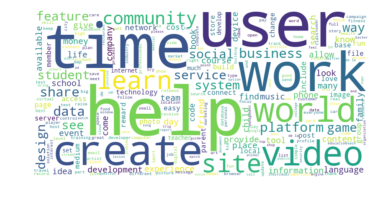

In [34]:
# Test with one project
text = corpus_text

# Generate word cloude image
wordcloud = WordCloud(max_font_size=80,
                     max_words=2000,
                     background_color="white",
                     width=400, 
                     height=200,
                     scale=2).generate(text)

# Display image
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### Future reading
Magnetic bubble charts (similar to Apple Music's genre selector):

https://github.com/efremidze/Magnetic

### Interactive chart with Bokeh

In [35]:
# Convert start/end_dt to datetime dates
df['funding_end_dt'] = df['funding_end_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
df['funding_start_dt'] = df['funding_start_dt'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

In [36]:
df['ending'] = df['funding_end_dt'].apply(lambda x: x.strftime("%Y")+'-'+x.strftime("%m"))

In [37]:
df['topics'] = df['pyLDAvis_topics_top3_clean']

In [38]:
# Reduce DataFrame to keep relevant columns only
df['successful_flg'] = df['successful'].apply(lambda x: 1 if x == True else 0)
df['tag_flg'] = df['tag'].apply(lambda x: 1 if x=='Project We Love' else 0)
DA_df = df[['project','ending','backers','pledged','goal','pct_funded','successful','tag','category','topics','successful_flg','tag_flg']]

In [39]:
DA_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7057 entries, 0 to 7056
Data columns (total 12 columns):
project           7056 non-null object
ending            7057 non-null object
backers           7054 non-null object
pledged           5313 non-null float64
goal              6406 non-null float64
pct_funded        4857 non-null float64
successful        7057 non-null bool
tag               147 non-null object
category          7052 non-null object
topics            7057 non-null object
successful_flg    7057 non-null int64
tag_flg           7057 non-null int64
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 613.4+ KB


In [40]:
# Get rid of records with None values
DA_df = DA_df[~DA_df['goal'].isnull()]
DA_df = DA_df[~DA_df['pledged'].isnull()]
DA_df = DA_df[~DA_df['category'].isnull()]
DA_df = DA_df[~DA_df['project'].isnull()]
DA_df = DA_df[~DA_df['backers'].isnull()]

# Get rid of records that have tag stored in category
DA_df = DA_df[DA_df['category'] != 'Project We Love']

In [41]:
DA_df.groupby(['category']).count()

,project,ending,backers,pledged,goal,pct_funded,successful,tag,topics,successful_flg,tag_flg
category,,,,,,,,,,,
Apps,1353,1353,1353,1353,1353,1353,1353,58,1353,1353,1353
Software,1625,1625,1625,1625,1625,1625,1625,64,1625,1625,1625
Web,1853,1853,1853,1853,1853,1853,1853,25,1853,1853,1853


## Plot with Bokeh

In [42]:
import bokeh
from bokeh.plotting import figure
from bokeh.io import output_file,show,save
from bokeh.models import PanTool, ResetTool, HoverTool, ColumnDataSource, Range1d
from bokeh.layouts import column
from bokeh.models.annotations import Label

In [43]:
# Define colormap and normalize size of bubble
colormap = {'Web':'#34495E','Apps':'crimson','Software':'goldenrod'}
DA_df['color'] = [colormap[x] for x in DA_df['category']]
DA_df['backers'] = DA_df['backers'].apply(lambda x: int(x))
DA_df['pledged'] = DA_df['pledged'].apply(lambda x: int(x))
DA_df['pct_funded_'] = DA_df['pct_funded'].apply(lambda x: int(x*100))
DA_df['pledged_'] = DA_df['pledged'].apply(lambda x: int(x/1000))
DA_df['backers_'] = DA_df['backers'].apply(lambda x: max(3,int(x/200)))
DA_df['mth'] = DA_df['ending'].apply(lambda x: int(x[:4])+int(x[-2:])/12)

# Create Column DataSource
web = ColumnDataSource(DA_df[DA_df['category'] == 'Web'])
apps = ColumnDataSource(DA_df[DA_df['category'] == 'Apps'])
software = ColumnDataSource(DA_df[DA_df['category'] == 'Software'])

# Prep output file
output_file('kickstarter_trend_spotter.html')

# Create figure object
f = figure(plot_height=650, 
           plot_width=1100,
           background_fill_color = "grey",
           background_fill_alpha=0.000,
           y_axis_type="log",
           x_axis_type="log")

# Set x,y range bounds
#f.x_range = Range1d(0,max(DA_df['pct_funded_']))
#f.y_range = Range1d(0,max(DA_df['pledged_']))

# Create glyphs
f.circle(x = "pct_funded_",
         y = "pledged_",
         size = "backers_",
         fill_alpha=0.7,
         color = "color", 
         legend = 'Web',
         source = web)

f.circle(x = "pct_funded_",
         y = "pledged_",
         size = "backers_",
         fill_alpha=0.7,
         color = "color", 
         legend = 'Apps',
         source = apps)

f.circle(x = "pct_funded_",
         y = "pledged_",
         size = "backers_",
         fill_alpha=0.7,
         color = "color", 
         legend = 'Software',
         source = software)

# Style the legend
f.legend.location = 'top_right'
#f.legend.background_fill_alpha = 0.3
f.legend.border_line_color = None
f.legend.margin = 20
f.legend.label_text_color = 'grey'

# Style the tools
#hover = HoverTool(tooltips=[("Topic","@topic"),("Pledged","@pledged"),("Backers","@backers")]) #("Project","@project"),
hover = HoverTool(tooltips="""
<div>
    <div>
        <span style="font-size: 15px; font-weight: bold; color: #34495E;">@project</span>
    </div>
    <div>
        <span style="font-size: 10px; color: #7F8C8D;">Pledged: @pledged</span><br>
        <span style="font-size: 10px; color: #7F8C8D;">Backers: @backers</span><br>
        <span style="font-size: 10px; color: #7F8C8D;">Goal: @goal</span><br>
        <span style="font-size: 10px; color: #7F8C8D;">% Funded: @pct_funded</span><br>
        <span style="font-size: 10px; color: #7F8C8D;">Topics: @topics</span>
    </div>
</div>
""")

f.add_tools(hover)
f.toolbar_location = 'below'
f.toolbar.logo = None # removes Bokeh logo

# Style the title
f.title.text = 'Kickstarter Trend Spotter' 
f.title.text_font_size = '44px'
#f.title.align = 'center'

# Style the axes
f.axis.minor_tick_line_color = 'grey'
f.xaxis.axis_label = '% Funded relative to goal'
f.yaxis.axis_label = 'Peldged Amount ($K)'
f.axis.axis_label_text_color = 'black'
f.axis.major_label_text_color = 'grey'
f.axis.axis_label_text_font_size = '12px'
f.axis.axis_label_text_align = 'right'

# Style the grid
f.grid.grid_line_dash = [5,3]

# Add Year-Month label
import calendar
yr_mth = "2017-12"
yr = yr_mth[:4]
mth = yr_mth[-2:]
label = Label(x = 15000,
              y = 1,
              text = calendar.month_abbr[int(mth)]+' '+yr,
              text_font_size='50pt',
              text_color='#eeeeee',
              render_mode="css")
f.add_layout(label)

# Merge plots inisde a gridplot layout
#F = column(f,f)

# Write plot in figure object
save(f)

'/Users/usamamostafa/Code/kickstarter_trend_spotter.html'

In [ ]:
#dir(f.grid)
import bokeh.models
dir(bokeh.models.tools)